In [1]:
%matplotlib inline

import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

plt.style.use('seaborn-whitegrid')

In [21]:
def summarize(alpha=0.05):

    def _summarize(ser):
        hpd_ = pm.hpd(ser, alpha=alpha)
        return pd.Series({
            'mean_': ser.mean(),
            'lower': hpd_[0],
            'upper': hpd_[1],
        })

    return _summarize


def agg_prediction(trace_var, source_data, group_columns, aggregate_fc):
    df = pd.DataFrame(trace_var).stack().reset_index().drop('level_0', axis=1)
    merged = pd.merge(
        df, source_data[group_columns],
        left_on='level_1', right_index=True
    )

    return (
        merged.groupby(group_columns)[0].apply(aggregate_fc)
        .unstack().sort_index().reset_index()
    )


**H1** In 1980, a typical Bengali woman could have 5 or more children in her lifetime. By the year 200, a typical Bengali woman had only 2 or 3. You’re going to look at a historical set of data, when contraception was widely available but many families chose not to use it. These data reside in `bangladesh` and come from the 1988 Bangladesh Fertility Survey. Each row is one of 1934 women. There are six variables, but you can focus on three of them for this practice problem:

* `district`: ID number of administrative district each woman resided in
* `use.contraception`: An indicator (0/1) of whether the woman was using contraception
* `urban`: An indicator (0/1) of whether the woman lived in a city, as opposed to living in a
rural area


In [2]:
data = pd.read_csv('../data/bangladesh.csv', sep=';')

districts = (data.district.drop_duplicates()
             .reset_index(drop=True).reset_index()
             .set_index('district')['index'].rename('district_id').to_frame())

data = pd.merge(data, districts, left_on='district', right_index=True)

data.sample(5)

,woman,district,use.contraception,living.children,age.centered,urban,district_id
714,715,21,0,4,-3.5599,1,20
1776,1777,56,1,4,17.4400,0,54
1110,1111,33,0,3,-2.5599,0,32
291,292,8,1,1,-10.5590,1,7
1475,1476,46,0,4,15.4400,0,45


Now, focus on predicting `use.contraception`, clustered by `district_id`. Do not include urban just yet. Fit both 

- (1) a traditional fixed-effects model that uses dummy variables for district and 
- (2) a multilevel model with varying intercepts for district. 



In [3]:
with pm.Model() as m_no_pooling:
    num_districts = data.district_id.nunique()

    alpha = pm.Normal('alpha', mu=0, sd=1.5, shape=num_districts)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            alpha[data.district_id.values]
        )
    )
    
    use_obs = pm.Binomial('use_obs', n=1, p=p,
                          observed=data['use.contraception'].values)
    
    m_no_pooling.name = 'no pooling'
    m_no_pooling.trace = pm.sample(5000, tune=1000, chains=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:30<00:00, 390.17draws/s]


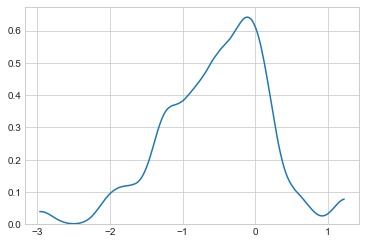

In [11]:
tmp = m_no_pooling.trace['alpha'].mean(axis=0)
pm.kdeplot(tmp)
None

In [12]:
with pm.Model() as m_hier:
    num_districts = data.district_id.nunique()

    a = pm.Normal('a', mu=0, sd=1)
    district_sd_bar = pm.Exponential('district_sd_bar', lam=1)

    district_a = pm.Normal('district_a', mu=0, sd=district_sd_bar,
                           shape=num_districts)

    p = pm.Deterministic(
        'p',
        pm.math.invlogit(
            a + district_a[data.district_id.values]
        )
    )

    use_obs = pm.Binomial('use_obs', n=1, p=p,
                          observed=data['use.contraception'].values)

    m_hier.name = 'hierarchical'
    m_hier.trace = pm.sample(5000, tune=1000, chains=2)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [district_a, district_sd_bar, a]
Sampling 2 chains: 100%|██████████| 12000/12000 [00:33<00:00, 363.37draws/s]


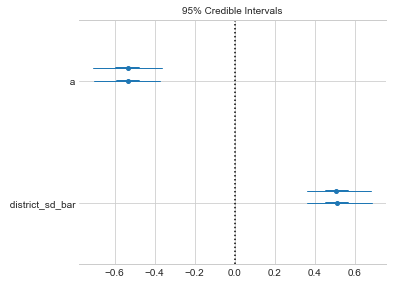

In [13]:
pm.forestplot(m_hier.trace, varnames=['a', 'district_sd_bar'], rhat=False)
None

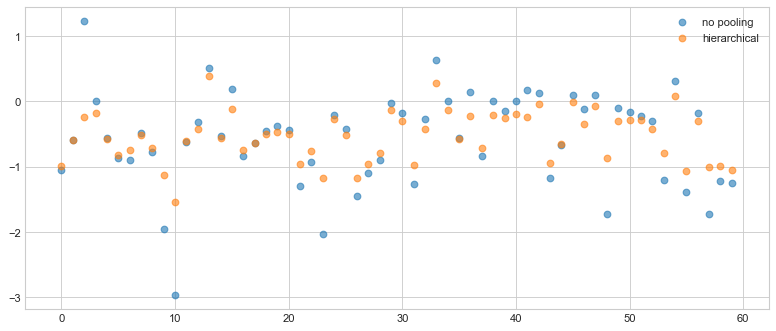

In [16]:
fig = plt.figure(figsize=(12, 5), dpi=80)
plt.scatter(np.arange(num_districts), m_no_pooling.trace['alpha'].mean(axis=0),
            label='no pooling', alpha=.6)
alpha_ = (m_hier.trace['a'].reshape(-1, 1) + m_hier.trace['district_a']).mean(axis=0)
plt.scatter(np.arange(num_districts), alpha_,
            label='hierarchical', alpha=.6)
plt.legend()
None

Plot the predicted proportions of women in each district using contraception, for both the fixed-effects model and the varying-effects model. That is, make a plot in which district ID is on the horizontal axis and expected proportion using contraception is on the vertical. Make one plot for each model, or layer them on the same plot, as you prefer. How do the models disagree? Can you explain the pattern of disagreement? In particular, can you explain the most extreme cases of disagreement, both why they happen where
they do and why the models reach different inferences?


In [25]:
tmp1 = agg_prediction(m_no_pooling.trace['p'], data, ['district_id'], summarize())
tmp2 = agg_prediction(m_hier.trace['p'], data, ['district_id'], summarize())

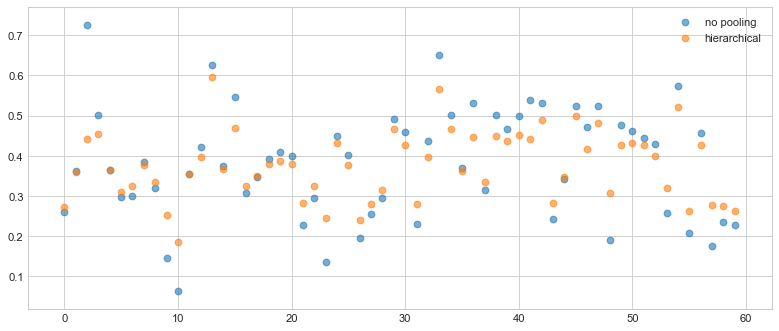

In [26]:
fig = plt.figure(figsize=(12, 5), dpi=80)

plt.scatter(tmp1.district_id, tmp1.mean_,
            label='no pooling', alpha=.6)
plt.scatter(tmp2.district_id, tmp2.mean_,
            label='hierarchical', alpha=.6)
plt.legend()
None

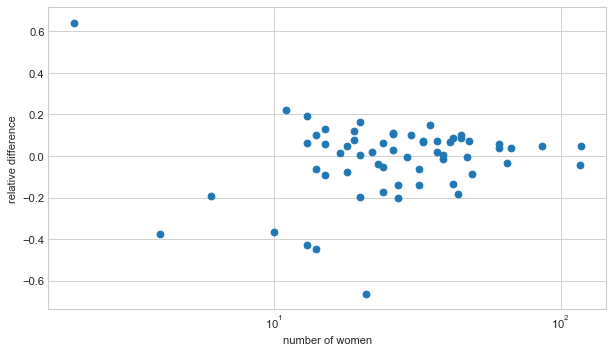

In [53]:
p_joined = tmp1.set_index('district_id')[['mean_']].join(
    tmp2.set_index('district_id').mean_.rename('hier_mean')
)
p_joined = p_joined.join(data.groupby('district_id').woman.nunique().rename('n_women'))
p_joined = p_joined.assign(diff_ = p_joined.mean_ - p_joined.hier_mean)
p_joined = p_joined.assign(rel_diff = p_joined.diff_/p_joined.hier_mean)

fig, ax = plt.subplots(1, 1, figsize=(9, 5), dpi=80)

ax.scatter(p_joined.n_women, p_joined.rel_diff)
ax.set(xscale='log', xlabel='number of women', ylabel='relative difference')

None

In [27]:
pm.compare({
    m_no_pooling: m_no_pooling.trace,
    m_hier: m_hier.trace,
})

/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:218: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
/home/petrushev/etc/jup_env/lib/python3.7/site-packages/pymc3/stats.py:167: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
hierarchical,2514.48,35.48,0,0.81,24.97,0,0
no pooling,2523.87,53.91,9.38,0.19,28.9,7.78,1
